# PPO Report

This notebook loads a pre-trained model and runs evaluation and visualization.
No training is required — just place the model `.zip` file in the expected path and run all cells.

---

In [1]:
import os, sys

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [2]:
# Configuration

SEED = 42

# "dqn" or "ppo"
SELECTED_ALGORITHM = "ppo"

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
OUTPUT_DIR = os.path.join(NOTEBOOK_DIR, "outputs_" + SELECTED_ALGORITHM)
MODEL_LOAD_PATH = os.path.join(NOTEBOOK_DIR, "../../../models", SELECTED_ALGORITHM, "model_" + SELECTED_ALGORITHM + "_1m")

GYMNASIUM_MODEL = "LunarLander-v3"

# Environment settings
WIND_ENABLED = False

EVALUATION_EPISODES = 100

# Algorithm class mapping
ALGORITHM_MAP = {"ppo": PPO, "dqn": DQN}
ALGORITHM_CLASS = ALGORITHM_MAP[SELECTED_ALGORITHM]

DEVICE = "cpu"

print(f"Algorithm: {SELECTED_ALGORITHM.upper()}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Model path: {MODEL_LOAD_PATH}")

Algorithm: PPO
Wind enabled: False
Model path: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/model_ppo_1m


In [3]:
# Load the pre-trained model

def make_env_lunarlander():
    env = gym.make(GYMNASIUM_MODEL,
                   render_mode="rgb_array",
                   enable_wind=WIND_ENABLED)
    env.reset(seed=SEED)
    return env

env = DummyVecEnv([make_env_lunarlander])

MODEL = ALGORITHM_CLASS.load(
    MODEL_LOAD_PATH,
    env=env,
    device=DEVICE)

print(f"Loaded {SELECTED_ALGORITHM.upper()} model from: {MODEL_LOAD_PATH}")

Loaded PPO model from: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/../../../models/ppo/model_ppo_1m


In [4]:
# Evaluation
evaluation_environment = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
evaluation_environment.reset(seed=SEED)

print(f"Starting Test: {EVALUATION_EPISODES} episodes...")

episode_rewards, _ = evaluate_policy(
    MODEL,
    evaluation_environment,
    n_eval_episodes=EVALUATION_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)

# Show statistics
rewards = np.array(episode_rewards)
stats = {
    "Metric": ["Mean Reward", "Standard Deviation", "Minimum Reward", "Maximum Reward", "Success Rate (Score > 200)"],
    "Value": [
        f"{np.mean(rewards):.2f}",
        f"{np.std(rewards):.2f}",
        f"{np.min(rewards):.2f}",
        f"{np.max(rewards):.2f}",
        f"{(rewards >= 200).sum() / EVALUATION_EPISODES * 100:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats)
print("\n*** MODEL EVALUATION SUMMARY ***")
print(df_stats.to_string(index=False))

evaluation_environment.close()

Starting Test: 100 episodes...

*** MODEL EVALUATION SUMMARY ***
                    Metric  Value
               Mean Reward 269.21
        Standard Deviation  33.28
            Minimum Reward  40.63
            Maximum Reward 312.81
Success Rate (Score > 200)  98.0%


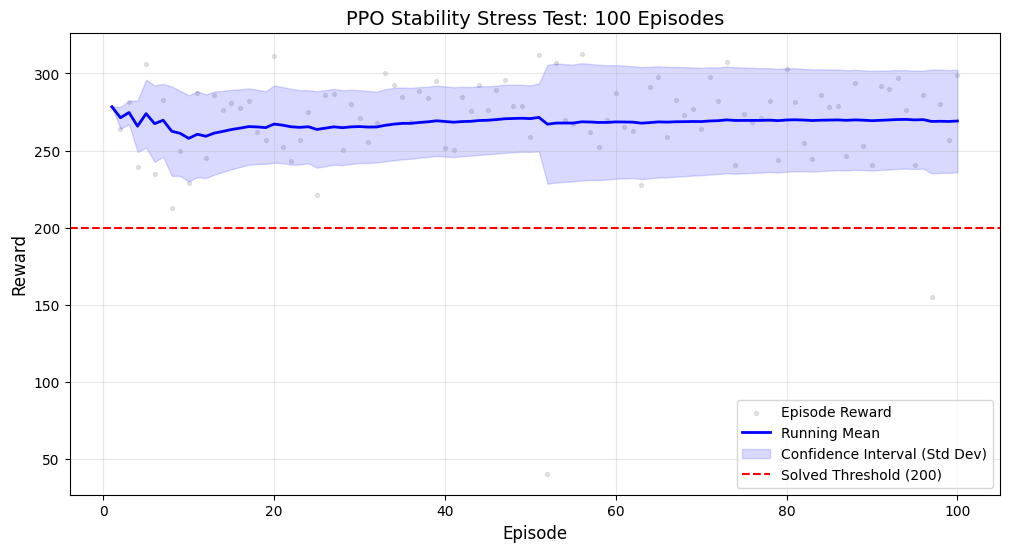

In [5]:
# Convergence Plot
episodes = np.arange(1, len(rewards) + 1)
running_mean = np.cumsum(rewards) / episodes
running_std = np.array([np.std(rewards[:i]) for i in episodes])

plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, color='gray', alpha=0.2, s=8, label='Episode Reward')
plt.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
plt.fill_between(episodes, running_mean - running_std, running_mean + running_std, color='blue', alpha=0.15, label='Confidence Interval (Std Dev)')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

plt.title(f"{SELECTED_ALGORITHM.upper()} Stability Stress Test: {EVALUATION_EPISODES} Episodes", fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

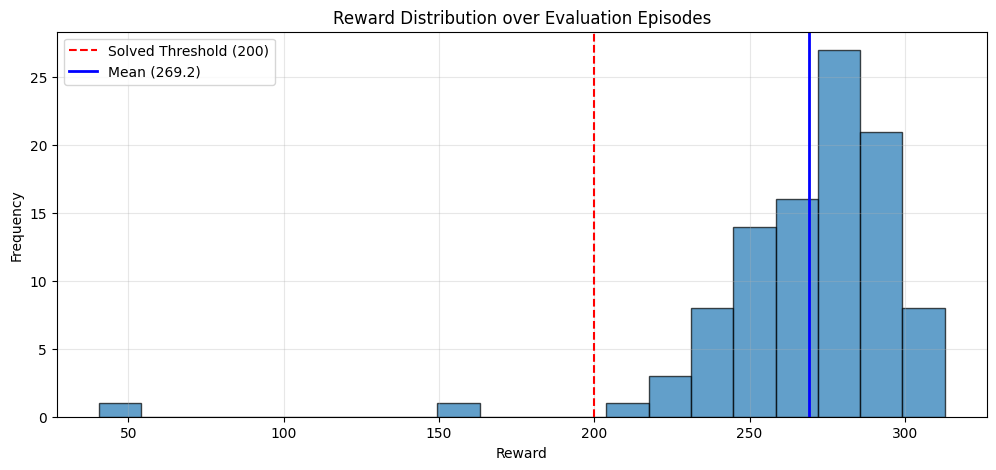

In [6]:
# Reward Distribution Histogram
plt.figure(figsize=(12, 5))
plt.hist(rewards, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.axvline(x=np.mean(rewards), color='blue', linestyle='-', linewidth=2, label=f'Mean ({np.mean(rewards):.1f})')
plt.title('Reward Distribution over Evaluation Episodes')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Saved visualization to: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_lunarlander.gif


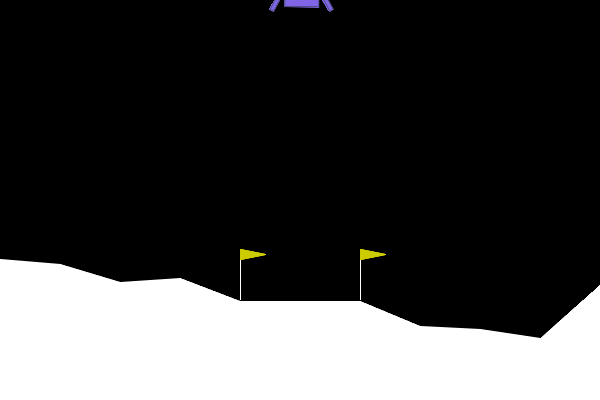

In [7]:
# GIF Visualization
visualization_environment = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)

frames = []
obs, info = visualization_environment.reset(seed=SEED)
done = False

while not done:
    action, _ = MODEL.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = visualization_environment.step(action)
    done = terminated or truncated
    frames.append(visualization_environment.render())

visualization_environment.close()

gif_path = os.path.join(OUTPUT_DIR, SELECTED_ALGORITHM + "_lunarlander.gif")
imageio.mimsave(gif_path, frames, fps=30)

print(f"Saved visualization to: {gif_path}")
Image(filename=gif_path)

---

## Additional plot cells can go below
